# **Proyecto Data Science 1**

# **Predicción de refuerzos en líneas de transporte público a partir del uso de SUBE**


#Estudiante: Gabriel Elvaz


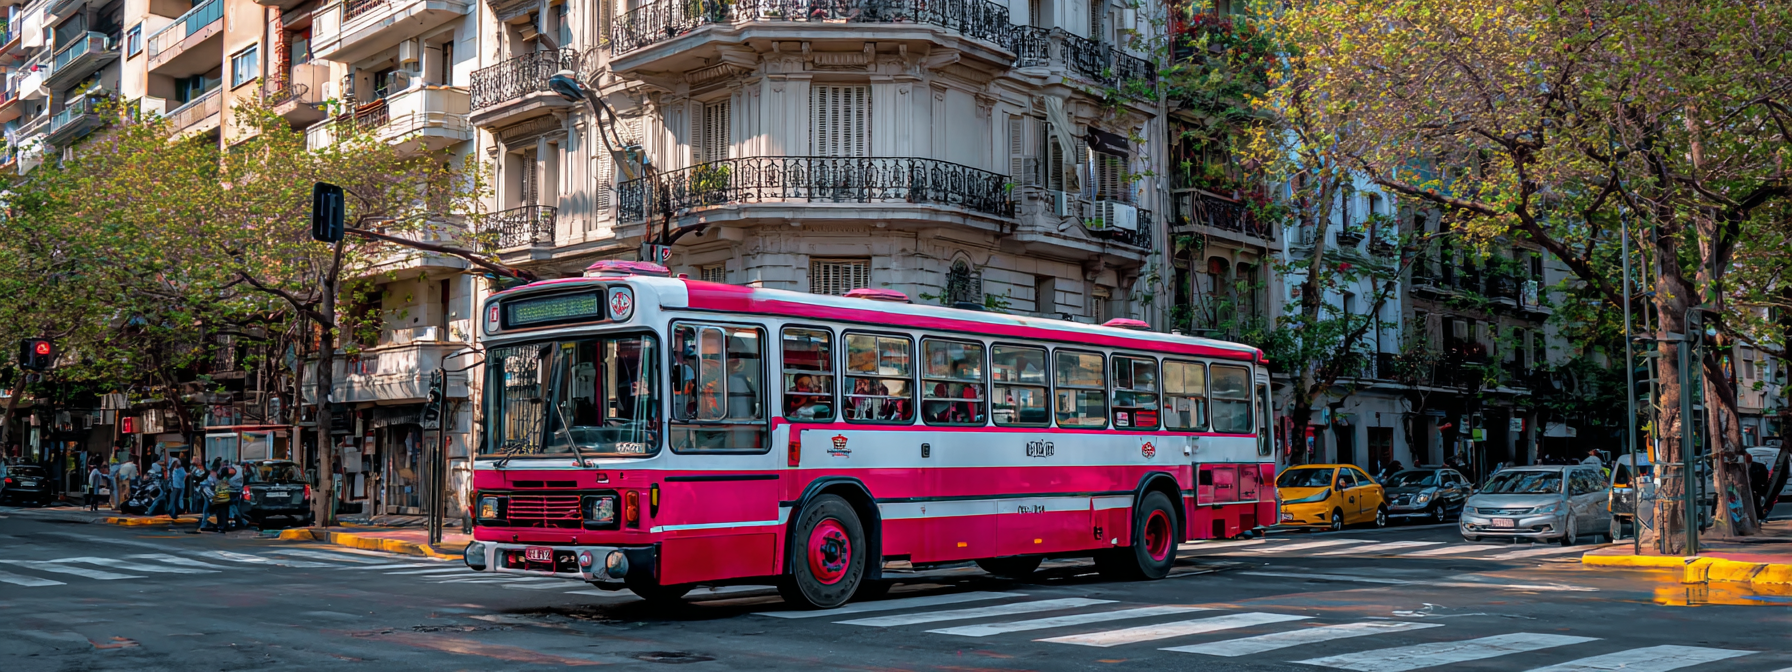

**Introducción**

En este trabajo vamos a abordar un problema relacionado con el transporte público y la gestión eficiente de recursos. La problemática central es identificar cuándo una línea de colectivo necesita refuerzo, es decir, si debe contar con unidades adicionales para cubrir la demanda en determinados días y zonas.

La idea es generar un modelo que, a partir de algunas variables como el día, el tipo de transporte, la provincia y si pertenece o no al AMBA, pueda anticipar si una línea va a requerir refuerzo. Esto podría ser útil para tomar decisiones operativas con tiempo y optimizar la asignación de recursos.

Para esto, trabajamos con un dataset proporcionado por la Subsecretaría de Transporte de la Nación, el cual contiene más de 240.000 registros con información sobre cantidad de uso de SUBE, tipo de transporte, provincia. y fechas.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data1_Entrega_Gabriel-Elvaz/dat-ab-usos-2025.csv')
df

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR
0,2025-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,1,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,23,NO
1,2025-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,2B,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,13,NO
2,2025-01-01,EMPRESA BATAN S.A.,BS_AS_LINEA 715M,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1401,NO
3,2025-01-01,EMPRESA BATAN S.A.,BS_AS_LINEA 720M,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,296,NO
4,2025-01-01,COMPAÑIA DE TRANSPORTE VECINAL S.A.,BS_AS_LINEA_326,SI,COLECTIVO,PROVINCIAL,BUENOS AIRES,SN,238,NO
...,...,...,...,...,...,...,...,...,...,...
244163,2025-06-23,TRANSPORTE BAHIA S.R.L.,TRELEW - PUERTO RAWSON,NO,COLECTIVO,PROVINCIAL,CHUBUT,SN,720,SI
244164,2025-06-23,S.A TRANSPORTE CIUDAD DE RIO CUARTO,TRONCAL A,NO,COLECTIVO,MUNICIPAL,CORDOBA,RIO CUARTO,458,SI
244165,2025-06-23,S.A TRANSPORTE CIUDAD DE RIO CUARTO,TRONCAL B,NO,COLECTIVO,MUNICIPAL,CORDOBA,RIO CUARTO,455,SI
244166,2025-06-23,S.A TRANSPORTE CIUDAD DE RIO CUARTO,TRONCAL C,NO,COLECTIVO,MUNICIPAL,CORDOBA,RIO CUARTO,306,SI


**Exploración inicial**

In [ ]:
df.info()
print(df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244168 entries, 0 to 244167
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   DIA_TRANSPORTE   244168 non-null  object
 1   NOMBRE_EMPRESA   244168 non-null  object
 2   LINEA            244168 non-null  object
 3   AMBA             244168 non-null  object
 4   TIPO_TRANSPORTE  244168 non-null  object
 5   JURISDICCION     242965 non-null  object
 6   PROVINCIA        242965 non-null  object
 7   MUNICIPIO        242965 non-null  object
 8   CANTIDAD         244168 non-null  int64 
 9   DATO_PRELIMINAR  244168 non-null  object
dtypes: int64(1), object(9)
memory usage: 18.6+ MB
DIA_TRANSPORTE     object
NOMBRE_EMPRESA     object
LINEA              object
AMBA               object
TIPO_TRANSPORTE    object
JURISDICCION       object
PROVINCIA          object
MUNICIPIO          object
CANTIDAD            int64
DATO_PRELIMINAR    object
dtype: object


In [ ]:
df.shape

(244168, 10)

In [ ]:
df.isna().sum().sort_values(ascending=False)[:10]

,0
PROVINCIA,1203
JURISDICCION,1203
MUNICIPIO,1203
DIA_TRANSPORTE,0
NOMBRE_EMPRESA,0
LINEA,0
TIPO_TRANSPORTE,0
AMBA,0
CANTIDAD,0
DATO_PRELIMINAR,0


Limpieza de datos

In [ ]:
porcentaje_de_nulos = df.isnull().mean()
print(porcentaje_de_nulos)

DIA_TRANSPORTE     0.000000
NOMBRE_EMPRESA     0.000000
LINEA              0.000000
AMBA               0.000000
TIPO_TRANSPORTE    0.000000
JURISDICCION       0.004927
PROVINCIA          0.004927
MUNICIPIO          0.004927
CANTIDAD           0.000000
DATO_PRELIMINAR    0.000000
dtype: float64


Aunque el porcentaje de nulos es bajo, se decidió borrar las filas ya que el analisis esta orientado a identificar zonas geograficas con mayor uso del sistema SUBE. Con los datos nulos podriamos tener resultados distorsionados o categorias incompletas.

In [ ]:
df_limpio = df.dropna(subset=['JURISDICCION', 'PROVINCIA', 'MUNICIPIO'])

In [ ]:
df = df[df['CANTIDAD'] >= 0]

In [ ]:
df['PROVINCIA'] = df['PROVINCIA'].replace({'CIUDAD AUTÓNOMA DE BUENOS AIRES': 'CABA', 'C.A.B.A': 'CABA', 'JN': 'JUJUY'}) #Se corrigieron los nombres que generaban provincias repetidas afectando los resultados.

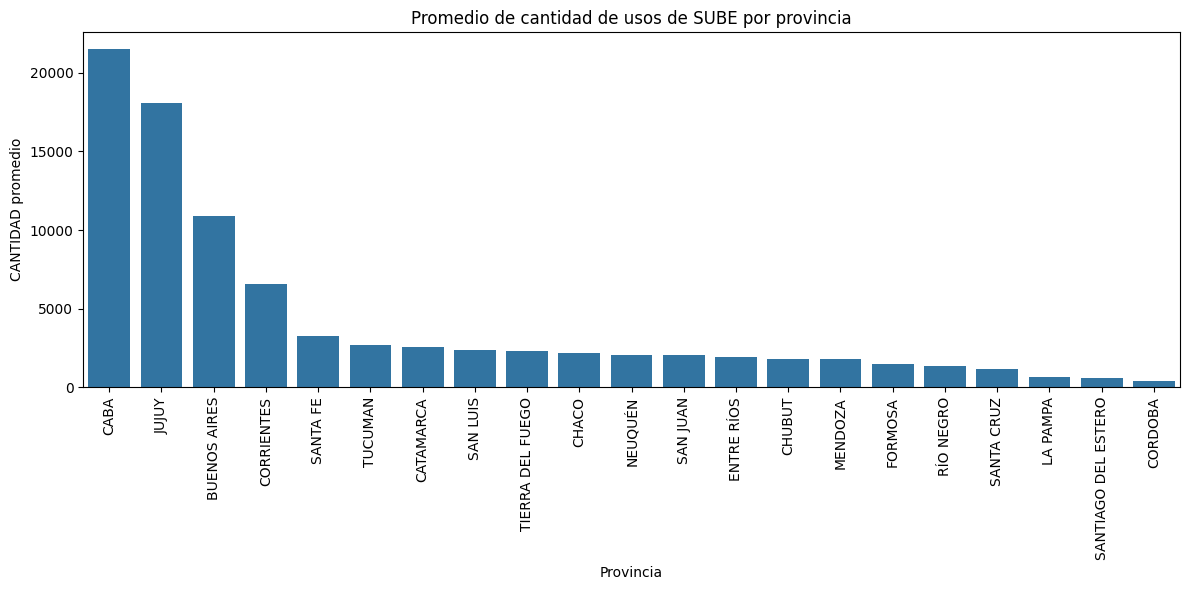

In [ ]:
prov_media = df.groupby('PROVINCIA')['CANTIDAD'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=prov_media.index, y=prov_media.values)
plt.xticks(rotation=90)
plt.title("Promedio de cantidad de usos de SUBE por provincia")
plt.ylabel("CANTIDAD promedio")
plt.xlabel("Provincia")
plt.tight_layout()
plt.show()

Comparativa de uso promedio en SUBE por provincia

A partir de la agrupación por provincia y el calculo promedio del promedio de la variable CANTIDAD, podemos identificar diferencias notables entre regiones, destacando en orde: CABA, Jujuy, Buenos Aires, Corrientes y Santa Fe

In [ ]:
top_provincias =  ['CABA','JUJUY', 'BUENOS AIRES']
df_top = df[df['PROVINCIA'].isin(top_provincias)]

df_top[['CANTIDAD']].describe()

,CANTIDAD
count,101868.000000
mean,13879.988181
std,23456.555304
min,1.000000
25%,1491.000000
50%,6343.000000
75%,18554.000000
max,467163.000000


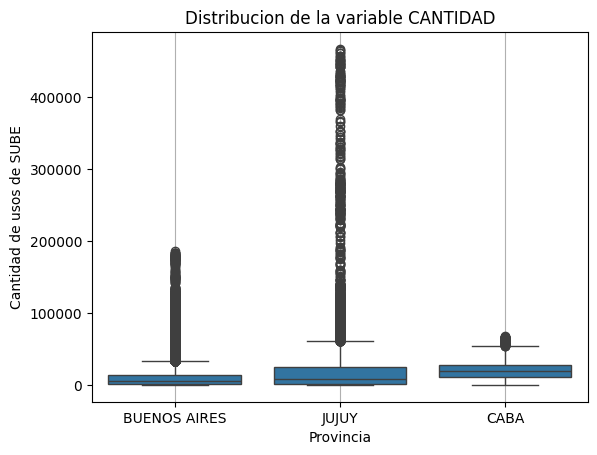

In [ ]:
sns.boxplot(x='PROVINCIA', y='CANTIDAD', data = df_top)
plt.title("Distribucion de la variable CANTIDAD")
plt.xlabel("Provincia")
plt.ylabel("Cantidad de usos de SUBE")
plt.grid(True, axis='x')
plt.show()

Al analizar la variable CANTIDAD, que representa la cantidad de usos de la tarjeta SUBE, utilicé .describe() para ver un resumen estadístico. Se observa que si bien el valor mínimo es 1, el máximo llega a más de 487.000, con una media de 13.789 y una mediana de 6.343. Esto indica que la distribución está bastante sesgada y que hay valores extremos (outliers).

Con un boxplot separado por provincia (CABA, Buenos Aires y Jujuy), se confirma que estos outliers están presentes en todas, pero en especial en Buenos Aires y Jujuy. Decidí no eliminarlos porque, si bien son valores atípicos, podrían estar reflejando días especiales o condiciones reales que sí afectan la demanda y por lo tanto pueden aportar al modelo.

En lugar de usar un modelo de regresión para predecir un valor exacto de la variable "CANTIDAD", opté por transformar el problema en uno de clasificación binaria, donde el objetivo es anticipar si una línea necesita o no refuerzo. Esta decisión se basó en que el propósito final es tomar una decisión operativa concreta, y clasificar en categorías facilita ese tipo de decisiones.


Para este caso, elegí RandomForest como modelo principal porque es robusto ante la presencia de outliers, una característica importante dado que, como se observa en el análisis exploratorio, existen valores atípicos muy marcados en la variable cantidad. Random Forest no se ve tan afectado por la escala de las variables ni por su distribución, y permite capturar relaciones no lineales entre variables sin necesidad de un ajuste complejo.

Además, se decidóí trabajar únicamente con tres provincias: CABA, Buenos Aires y Jujuy. Esta selección se hizo porque eran las que contaban con mayor cantidad de registros.

In [ ]:
def clasificar_demanda(x):
    if x < 3000:
        return 'Baja'
    elif x < 10000:
        return 'Media'
    else:
        return 'Alta'

df_top['DEMANDA'] = df_top['CANTIDAD'].apply(clasificar_demanda)
print(df_top['DEMANDA'].value_counts())

DEMANDA
Alta     40692
Baja     35711
Media    25465
Name: count, dtype: int64


/tmp/ipython-input-18-3521711930.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top['DEMANDA'] = df_top['CANTIDAD'].apply(clasificar_demanda)


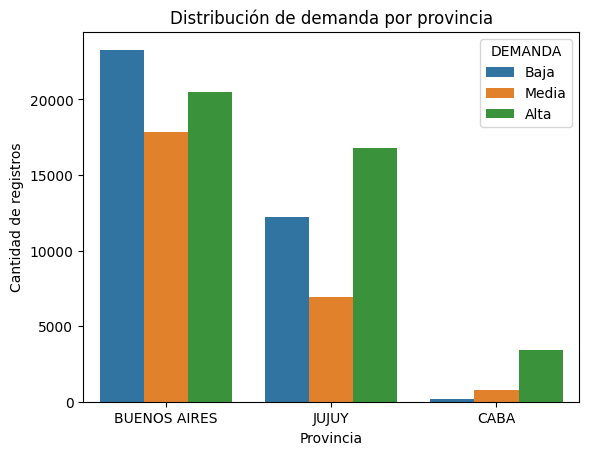

In [ ]:
sns.countplot(x='PROVINCIA', hue='DEMANDA', data=df_top, order=['BUENOS AIRES', 'JUJUY', 'CABA'])
plt.title("Distribución de demanda por provincia")
plt.xlabel("Provincia")
plt.ylabel("Cantidad de registros")
plt.show()

Según el gráfico, podemos observar que en CABA hay menos registros pero concentra alta demanda de uso de SUBE. En Buenos Aires y Jujuy se observa una distribución mas amplia de los niveles de demanda.

In [ ]:
df_top['DIA_TRANSPORTE'] = pd.to_datetime(df_top['DIA_TRANSPORTE'])
df_top['DIA_SEMANA'] = df_top['DIA_TRANSPORTE'].dt.day_name()
df_top['MES'] = df_top['DIA_TRANSPORTE'].dt.month
df_top['MES_NOMBRE'] = df_top['DIA_TRANSPORTE'].dt.month_name()

/tmp/ipython-input-20-2596545853.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top['DIA_TRANSPORTE'] = pd.to_datetime(df_top['DIA_TRANSPORTE'])
/tmp/ipython-input-20-2596545853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top['DIA_SEMANA'] = df_top['DIA_TRANSPORTE'].dt.day_name()
/tmp/ipython-input-20-2596545853.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [ ]:
df_top.head(5)

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR,DEMANDA,DIA_SEMANA,MES,MES_NOMBRE
0,2025-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,1,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,23,NO,Baja,Wednesday,1,January
1,2025-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,2B,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,13,NO,Baja,Wednesday,1,January
2,2025-01-01,EMPRESA BATAN S.A.,BS_AS_LINEA 715M,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1401,NO,Baja,Wednesday,1,January
3,2025-01-01,EMPRESA BATAN S.A.,BS_AS_LINEA 720M,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,296,NO,Baja,Wednesday,1,January
4,2025-01-01,COMPAÑIA DE TRANSPORTE VECINAL S.A.,BS_AS_LINEA_326,SI,COLECTIVO,PROVINCIAL,BUENOS AIRES,SN,238,NO,Baja,Wednesday,1,January


**Entrenamiento de modelo - RandomForest**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
le_prov = LabelEncoder()
le_tipo = LabelEncoder()
le_amba = LabelEncoder()
le_dia = LabelEncoder()
le_demanda = LabelEncoder()
le_mes = LabelEncoder()
le_linea = LabelEncoder()

In [ ]:
df_top['PROVINCIA_ENC'] = le_prov.fit_transform(df_top['PROVINCIA'])
df_top['TIPO_TRANSPORTE_ENC'] = le_tipo.fit_transform(df_top['TIPO_TRANSPORTE'])
df_top['AMBA_ENC'] = le_amba.fit_transform(df_top['AMBA'])
df_top['DIA_SEMANA_ENC'] = le_dia.fit_transform(df_top['DIA_SEMANA'])
df_top['DEMANDA_ENC'] = le_demanda.fit_transform(df_top['DEMANDA'])
df_top['MES_NOMBRE_ENC'] = le_mes.fit_transform(df_top['MES_NOMBRE'])
df_top['LINEA_ENC'] = le_linea.fit_transform(df_top['LINEA'])

/tmp/ipython-input-81-836343691.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top['PROVINCIA_ENC'] = le_prov.fit_transform(df_top['PROVINCIA'])
/tmp/ipython-input-81-836343691.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top['TIPO_TRANSPORTE_ENC'] = le_tipo.fit_transform(df_top['TIPO_TRANSPORTE'])
/tmp/ipython-input-81-836343691.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [ ]:
x = df_top[['PROVINCIA_ENC', 'TIPO_TRANSPORTE_ENC', 'AMBA_ENC', 'DIA_SEMANA_ENC', 'MES_NOMBRE_ENC']]
y = df_top['DEMANDA_ENC']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = modelo.predict(x_test)
print(classification_report(y_test, y_pred, target_names=le_demanda.classes_))

              precision    recall  f1-score   support

        Alta       0.62      0.91      0.74     12105
        Baja       0.65      0.73      0.69     10794
       Media       0.48      0.04      0.08      7662

    accuracy                           0.63     30561
   macro avg       0.58      0.56      0.50     30561
weighted avg       0.59      0.63      0.55     30561



Según la evaluación de rendimiento, podemos destacar que las categorias Alta y Baja, tienen porcentajes de acierto de prección aceptables. En la categoria Media, no se da de esta manera, hay poca presicion y poca detección de casos reales.

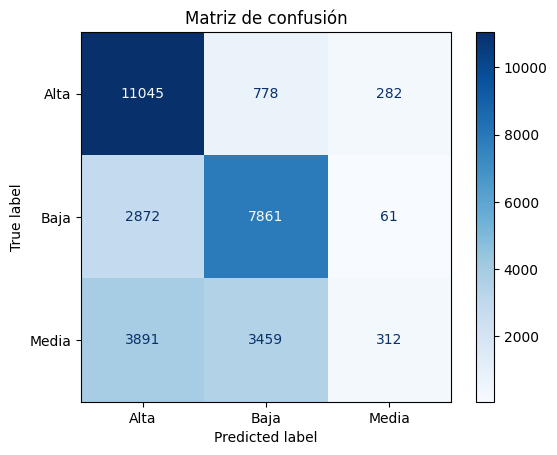

In [ ]:
matriz_confusion = confusion_matrix(y_test, y_pred)

disp =  ConfusionMatrixDisplay(confusion_matrix=matriz_confusion, display_labels=le_demanda.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de confusión")
plt.grid(False)
plt.show()

**De acuerdo a la matriz de confusión:**

Alta: tiene pocas confusiones con Baja (778) y Media(282)

Baja: tiene pocas confusiones con Media(61) pero una cantidad considerable con Alta(2872)

Media: es la categoria con peor rendimiento, el modelo no es capaz de definirla bien, tiene gran cantidad de confusiones con Alta(3891) y con Baja(3459)

Como conclusión, podemos trabajar con nuestra problematica con la categoria Alta que es las que nos brindara indicadores de cuando aplicar refuerzos o considerar mejores vías.

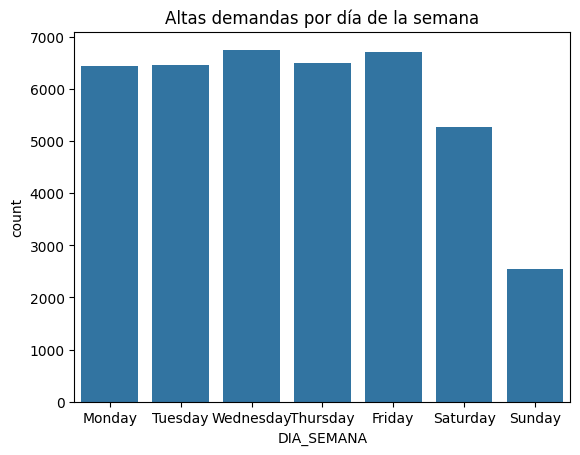

In [ ]:
demanda_alta = df_top[df_top['DEMANDA']== 'Alta']

sns.countplot(data=demanda_alta, x='DIA_SEMANA', order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
plt.title('Altas demandas por día de la semana')
plt.show()


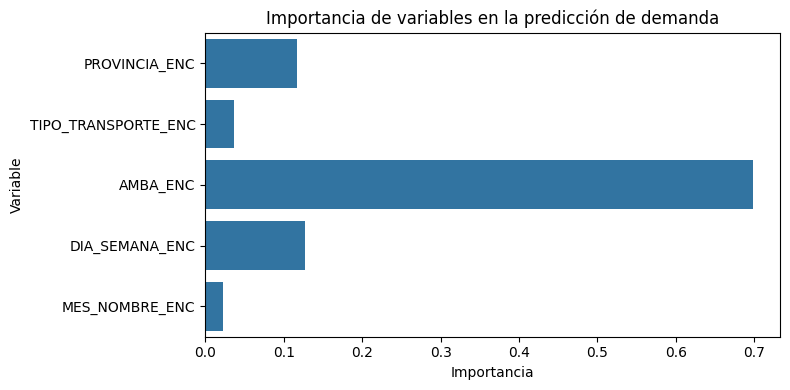

In [ ]:
importancia_vars = modelo.feature_importances_
variables = x.columns

plt.figure(figsize=(8, 4))
sns.barplot(x=importancia_vars, y=variables)
plt.title("Importancia de variables en la predicción de demanda")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

In [ ]:
print(df_top['MES_NOMBRE'].unique())

['January' 'February' 'March' 'April' 'May' 'June']


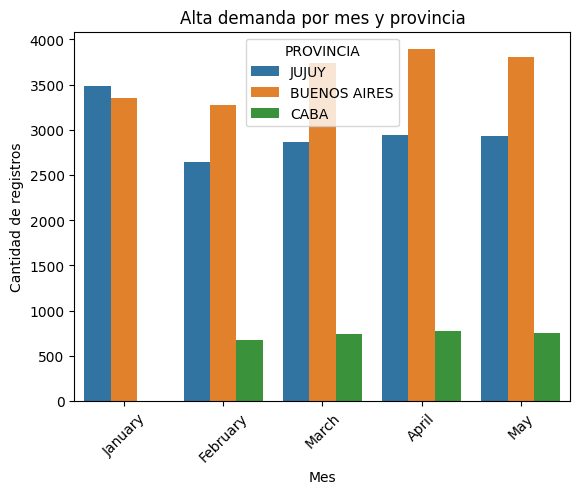

In [ ]:
sns.countplot(data=demanda_alta, x='MES_NOMBRE', hue='PROVINCIA', order=orden_meses)
plt.title('Alta demanda por mes y provincia')
plt.ylabel('Cantidad de registros')
plt.xlabel('Mes')
plt.xticks(rotation=45)
plt.show()

In [ ]:
lineas_mas_usadas = demanda_alta['LINEA'].value_counts().reset_index()
lineas_mas_usadas.columns = ['LINEA', 'CANTIDAD']

In [ ]:
nuevo_registro = {
    'DIA_SEMANA': 'Wednesday',
    'MES_NOMBRE': 'March',
    'PROVINCIA': 'CABA',
    'TIPO_TRANSPORTE': 'COLECTIVO',
    'AMBA': 'SI'
}

nuevo_X = [[
    le_dia.transform([nuevo_registro['DIA_SEMANA']])[0],
    le_mes.transform([nuevo_registro['MES_NOMBRE']])[0],
    le_prov.transform([nuevo_registro['PROVINCIA']])[0],
    le_tipo.transform([nuevo_registro['TIPO_TRANSPORTE']])[0],
    le_amba.transform([nuevo_registro['AMBA']])[0]
]]

prediccion = modelo.predict(nuevo_X)
demanda_predicha = le_demanda.inverse_transform(prediccion)[0]

print("Día:", nuevo_registro['DIA_SEMANA'])
print("Mes:", nuevo_registro['MES_NOMBRE'])
print("Provincia:", nuevo_registro['PROVINCIA'])
print("Transporte:", nuevo_registro['TIPO_TRANSPORTE'])
print("¿Es AMBA?:", nuevo_registro['AMBA'])
print("Predicción de demanda:", demanda_predicha)

Día: Wednesday
Mes: March
Provincia: CABA
Transporte: COLECTIVO
¿Es AMBA?: SI
Predicción de demanda: Alta


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



---

En un primer analisis, el entrenamiento con RadomForest no brindaba una buena precisión en la categoria de media demanda, por lo cual hago esta segunda etapa de analisis donde se agregan como variables las lineas de transporte, con el objetivo de tener resultados sobre si necesitan o no refuerzo en una fecha solicitada.


In [ ]:
df_top['REFUERZO'] = df_top['DEMANDA_ENC'].apply(lambda x: 1 if x == le_demanda.transform(['Alta'])[0] else 0)

X = df_top[['LINEA_ENC', 'DIA_SEMANA_ENC', 'MES_NOMBRE_ENC', 'PROVINCIA_ENC', 'AMBA_ENC', 'TIPO_TRANSPORTE_ENC']]
y = df_top['REFUERZO']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

modelo_refuerzo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_refuerzo.fit(X_train, y_train)


/tmp/ipython-input-84-3366881388.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top['REFUERZO'] = df_top['DEMANDA_ENC'].apply(lambda x: 1 if x == le_demanda.transform(['Alta'])[0] else 0)


RandomForestClassifier(random_state=42)

In [ ]:
y_pred = modelo_refuerzo.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     18456
           1       0.91      0.93      0.92     12105

    accuracy                           0.94     30561
   macro avg       0.93      0.94      0.94     30561
weighted avg       0.94      0.94      0.94     30561



El entrenamiento arroja resultados con alto porcentaje de precisión, tanto para los que no necesitan refuerzo como los que si.

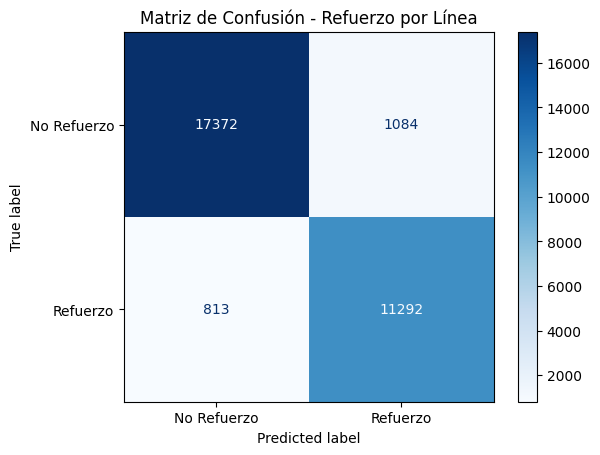

In [ ]:
matriz = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(matriz, display_labels=["No Refuerzo", "Refuerzo"])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión - Refuerzo por Línea")
plt.grid(False)
plt.show()

**De acuerdo a la matriz de confusión:**

El modelo predice correctamente la mayoría de los casos, hay una tasa baja de errores tanto de falsos positivos como de falsos negativos.

El modelo es confiable y equilibrado para implementación operativa.

In [ ]:
df_top['LINEA'].unique()

array(['1', '2B', 'BS_AS_LINEA 715M', 'BS_AS_LINEA 720M',
       'BS_AS_LINEA_326', 'BS_AS_LINEA_512', 'BS_AS_LINEA_522',
       'BS_AS_LINEA_527', 'BS_ASLINEA_123', 'BSAS_LINEA_002',
       'BSAS_LINEA_009', 'BSAS_LINEA_010', 'BSAS_LINEA_015',
       'BSAS_LINEA_017', 'BSAS_LINEA_019', 'BSAS_LINEA_020',
       'BSAS_LINEA_021', 'BSAS_LINEA_022', 'BSAS_LINEA_024',
       'BSAS_LINEA_026', 'BSAS_LINEA_029', 'BSAS_LINEA_032',
       'BSAS_LINEA_034', 'BSAS_LINEA_037', 'BSAS_LINEA_039',
       'BSAS_LINEA_041', 'BSAS_LINEA_045', 'BSAS_LINEA_046',
       'BSAS_LINEA_047', 'BSAS_LINEA_049', 'BSAS_LINEA_051',
       'BSAS_LINEA_053', 'BSAS_LINEA_055', 'BSAS_LINEA_056',
       'BSAS_LINEA_057', 'BSAS_LINEA_059', 'BSAS_LINEA_060',
       'BSAS_LINEA_061', 'BSAS_LINEA_062', 'BSAS_LINEA_063',
       'BSAS_LINEA_064', 'BSAS_LINEA_065', 'BSAS_LINEA_067',
       'BSAS_LINEA_068', 'BSAS_LINEA_070', 'BSAS_LINEA_071',
       'BSAS_LINEA_074', 'BSAS_LINEA_075', 'BSAS_LINEA_078',
       'BSAS_LINEA_079'

**Prueba del modelo entrenado**

In [ ]:
nuevo_refuerzo = {
    'LINEA': 'BSAS_LINEA_039',
    'DIA_SEMANA': 'Wednesday',
    'MES_NOMBRE': 'March',
    'PROVINCIA': 'CABA',
    'AMBA': 'SI',
    'TIPO_TRANSPORTE': 'COLECTIVO'
}

nuevo_X_ref = [[
    le_linea.transform([nuevo_refuerzo['LINEA']])[0],
    le_dia.transform([nuevo_refuerzo['DIA_SEMANA']])[0],
    le_mes.transform([nuevo_refuerzo['MES_NOMBRE']])[0],
    le_prov.transform([nuevo_refuerzo['PROVINCIA']])[0],
    le_amba.transform([nuevo_refuerzo['AMBA']])[0],
    le_tipo.transform([nuevo_refuerzo['TIPO_TRANSPORTE']])[0],
]]

prediccion_refuerzo = modelo_refuerzo.predict(nuevo_X_ref)[0]

print("Línea:", nuevo_refuerzo['LINEA'])
print("Día:", nuevo_refuerzo['DIA_SEMANA'])
print("Mes:", nuevo_refuerzo['MES_NOMBRE'])
print("Provincia:", nuevo_refuerzo['PROVINCIA'])
print("Transporte:", nuevo_refuerzo['TIPO_TRANSPORTE'])
print("¿Es AMBA?:", nuevo_refuerzo['AMBA'])
print("¿Necesita refuerzo?:", "Sí" if prediccion_refuerzo == 1 else "No")

Línea: BSAS_LINEA_039
Día: Wednesday
Mes: March
Provincia: CABA
Transporte: COLECTIVO
¿Es AMBA?: SI
¿Necesita refuerzo?: Sí


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


**Conclusión**

A partir del análisis realizado con datos de transporte, desarrolle dos modelos predictivos utilizando algoritmos de clasificación. En la primera etapa, el objetivo fue predecir la demanda esperada en función de variables como el día, el mes, la provincia, el tipo de transporte y si se trata de AMBA o no. En la segunda etapa, el objetivo fue predecir si una línea específica requiere refuerzo.

Los resultados fueron positivos en ambos casos:

  - En la primera predicción, el modelo logró una buena capacidad para estimar la demanda utilizando un Random Forest entrenado con variables codificadas.

  - En la segunda etapa, el modelo de clasificación alcanzó una precisión del 94%, con un recall del 93% y un f1-score general de 94%, lo que indica un buen equilibrio entre sensibilidad y precisión.

  - La matriz de confusión muestra que el modelo acierta en la mayoría de los casos al identificar correctamente si una línea necesita refuerzo, aunque existe un pequeño margen de error (principalmente falsos positivos o negativos).


Se concluye que el uso de algoritmos de aprendizaje supervisado como Random Forest permite identificar patrones útiles para la toma de decisiones operativas en el sistema de transporte, como anticipar la demanda y planificar refuerzos en líneas específicas.

🧡 🦆 🦾